# Match + Feature Engineering

This notebook provides a clean interface for matching bibliography items with references and extracting features.

## Overview

The notebook uses utility functions from `src/match_utils.py` and `src/feature_engineering_utils.py` to:
- Match bibliography items with references using TF-IDF matching
- Extract features for matched pairs (levenshtein, jaccard, year matching, etc.)
- Generate train/validation/test splits
- Create prediction files (`pred.json`) for each paper

## Features

- **TF-IDF Matching**: Uses TF-IDF cosine similarity for initial matching
- **Feature Extraction**: Computes multiple similarity features
- **Data Splitting**: Automatic train/val/test split with configurable ratios
- **Manual Candidates**: Support for manually labeled candidates
- **Progress Tracking**: Optional progress bars using tqdm


## Configuration

Configure the matching and feature extraction pipeline by setting the following parameters:

- **`NEG_PER_POS`**: Number of negative samples per positive sample
- **`MATCH_THRESHOLD`**: TF-IDF matching threshold for positive pairs
- **`HARD_NEGATIVES`**: Use hard negative sampling (top TF-IDF negatives)
- **`KEEP_ALL_NEGATIVES`**: Keep all negative candidates (no sampling)
- **`RANDOM_SEED`**: Random seed for reproducibility
- **`START`**: Starting paper ID filter
- **`NUM`**: Maximum number of papers to process
- **`MAX_REFS`**: Maximum references per paper (None for no limit)
- **`MAX_BIBS`**: Maximum bibitems per paper (None for no limit)

**Note**: Existing output files will be overwritten.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setup paths and import utilities
import sys
from pathlib import Path

# Add src to path for imports
ROOT = Path("/content/drive/MyDrive/23120334").resolve()
sys.path.append(str(ROOT / "src"))

from match_utils import (
    load_grouped_subset,
    load_manual_candidates,
    get_target_paper_ids,
    process_manual_candidates,
    run_matching_and_feature_extraction,
    split_data,
    compute_statistics
)

# ============================================================================
# Configuration
# ============================================================================

# Matching parameters
NEG_PER_POS = 10            # Number of negative samples per positive (harder data)
MATCH_THRESHOLD = 0.7       # Lower threshold to include more candidates (harder)
TFIDF_SCOPE = "paper"       # "paper" (fit per paper) or "split" (fit per split)
HARD_NEGATIVES = True       # Use hard negatives (top TF-IDF negatives)
KEEP_ALL_NEGATIVES = False  # Set True to keep all negatives (very large output)
RANDOM_SEED = 23120334      # Random seed for reproducibility

# Paper filtering
START = "2408-02468"        # Starting paper ID filter
NUM = 600                   # Maximum papers to process (None for all)
MAX_REFS = 200             # Maximum references per paper (None for no limit)
MAX_BIBS = 200             # Maximum bibitems per paper (None for no limit)

# Split configuration
TEST_IDS = []               # Predefined test paper IDs (empty for auto-selection)
VAL_IDS = []                # Predefined validation paper IDs (empty for auto-selection)
TARGET_TEST_PCT = 0.125     # Target percentage for test set (12.5%)
TARGET_VAL_PCT = 0.125      # Target percentage for validation set (12.5%)

# Paths
AGG = ROOT / "aggregated"
BIB_PATH = AGG / "bibitems.jsonl"
REF_PATH = AGG / "references.jsonl"
OUT_PATH = AGG / "matches_fe.jsonl"
MANUAL_PATH = AGG / "manual_candidates.json"
SPLIT_DIR = ROOT / "split"
PRED_DIR = ROOT / "23120334"

# Display configuration
print("=" * 60)
print("CONFIGURATION")
print("=" * 60)

def display_path(path_value: Path) -> str:
    try:
        relative = Path(path_value).resolve().relative_to(ROOT)
        return str(Path(ROOT.name) / relative)
    except ValueError:
        return str(path_value)

print(f"Root directory:        {ROOT.name}")
print(f"Bibitems input:        {display_path(BIB_PATH)}")
print(f"References input:      {display_path(REF_PATH)}")
print(f"Matches output:        {display_path(OUT_PATH)}")
print(f"Split directory:       {display_path(SPLIT_DIR)}")
print(f"Prediction directory:  {display_path(PRED_DIR)}")
print(f"Matching threshold:    {MATCH_THRESHOLD}")
print(f"TF-IDF scope:          {TFIDF_SCOPE}")
print(f"Negatives per pos:     {NEG_PER_POS}")
print(f"Hard negatives:        {HARD_NEGATIVES}")
print(f"Keep all negatives:    {KEEP_ALL_NEGATIVES}")
print(f"Max refs per paper:   {MAX_REFS}")
print(f"Max bibs per paper:   {MAX_BIBS}")
print(f"Start filter:          {START}")
print(f"Max papers:            {NUM}")
print("=" * 60)


CONFIGURATION
Root directory:        23120334
Bibitems input:        23120334\aggregated\bibitems.jsonl
References input:      23120334\aggregated\references.jsonl
Matches output:        23120334\aggregated\matches_fe.jsonl
Split directory:       23120334\split
Prediction directory:  23120334\23120334
Matching threshold:    0.7
TF-IDF scope:          paper
Negatives per pos:     10
Hard negatives:        True
Keep all negatives:    False
Max refs per paper:   200
Max bibs per paper:   200
Start filter:          2408-02468
Max papers:            600


## Load Manual Candidates

Load manually labeled candidates if available. These will be included in the matching process with label=1.


In [ ]:
# Load manual candidates
MANUAL_MAP = load_manual_candidates(MANUAL_PATH)
if MANUAL_MAP:
    print(f"Loaded {len(MANUAL_MAP)} papers with manual candidates")
else:
    print("No manual candidates found")

# Get target paper IDs
TARGET_IDS, MANUAL_IDS = get_target_paper_ids(
    bib_path=BIB_PATH,
    manual_map=MANUAL_MAP,
    start=START,
    num=NUM
)

print(f"\nTarget papers: {len(TARGET_IDS)}")
print(f"Manual papers: {len(MANUAL_IDS)}")



Loaded 5 papers with manual candidates

Target papers: 600
Manual papers: 5


## Run Matching and Feature Engineering

Execute the matching pipeline:
1. Load bibliography items and references
2. Process manual candidates (if available)
3. Run TF-IDF matching for automatic pairs
4. Extract features for all pairs
5. Write results to `matches_fe.jsonl`



In [ ]:
# Load data grouped by paper_id
bib_by_pid = load_grouped_subset(BIB_PATH, TARGET_IDS)
ref_by_pid = load_grouped_subset(REF_PATH, TARGET_IDS)

# Filter papers that have both bibitems and references
all_papers = sorted(set(bib_by_pid.keys()) | set(ref_by_pid.keys()))
available = [
    p for p in all_papers
    if bib_by_pid.get(p) and ref_by_pid.get(p) and p not in MANUAL_MAP
]

# Apply NUM limit
if NUM is not None:
    paper_ids = available[:NUM]
else:
    paper_ids = available

print(f"\nPapers usable (bib & ref): {len(available)}")
print(f"Processing: {len(paper_ids)}")
print(
    f"Using TF-IDF matching with threshold={MATCH_THRESHOLD}, scope={TFIDF_SCOPE}, "
    f"NEG_PER_POS={NEG_PER_POS}, hard_negatives={HARD_NEGATIVES}, "
    f"keep_all_negatives={KEEP_ALL_NEGATIVES}"
)

# Process manual candidates first (write mode)
manual_matched = 0
manual_written = 0
if MANUAL_MAP:
    OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    with OUT_PATH.open("w", encoding="utf-8") as out:
        manual_matched, manual_written = process_manual_candidates(
            manual_map=MANUAL_MAP,
            bib_by_pid=bib_by_pid,
            ref_by_pid=ref_by_pid,
            output_file=out
        )
    print(f"Manual candidates: {manual_matched} matched, {manual_written} written")

# Run matching and feature extraction (append mode if manual exists)
matched, written = run_matching_and_feature_extraction(
    bib_by_pid=bib_by_pid,
    ref_by_pid=ref_by_pid,
    paper_ids=paper_ids,
    output_path=OUT_PATH,
    match_threshold=MATCH_THRESHOLD,
    neg_per_pos=NEG_PER_POS,
    hard_negatives=HARD_NEGATIVES,
    keep_all_negatives=KEEP_ALL_NEGATIVES,
    max_refs=MAX_REFS,
    max_bibs=MAX_BIBS,
    random_seed=RANDOM_SEED,
    show_progress=True,
    append=bool(MANUAL_MAP),  # Append if manual candidates were written
    tfidf_scope=TFIDF_SCOPE
)

print(f"\nDone. Matched pairs: {matched}, Total rows written: {written + manual_written}")



Papers usable (bib & ref): 527
Processing: 527
Using TF-IDF matching with threshold=0.7, scope=paper, NEG_PER_POS=10, hard_negatives=True, keep_all_negatives=False
Manual candidates: 126 matched, 126 written


Papers:   0%|          | 0/527 [00:00<?, ?it/s]


Done. Matched pairs: 30142, Total rows written: 494451


## Statistics

Compute and display statistics from the matching results:
- Label distribution (0/1 counts)
- Sample rows for verification


In [ ]:
# Compute and display statistics
stats = compute_statistics(OUT_PATH, num_samples=5)

print("=" * 60)
print("STATISTICS")
print("=" * 60)
print("Label counts:", stats["labels"])
print("\nSample rows:")
for i, row in enumerate(stats["samples"], 1):
    print(f"\n[{i}]")
    for key, value in row.items():
        print(f"  {key}: {value}")
print("=" * 60)



STATISTICS
Label counts: {1: 30268, 0: 464183}

Sample rows:

[1]
  paper_id: 2408-02487
  bib_key: xu2023licensecom
  cand_id: 2308-05942
  score: 1.0
  levenshtein: 0.0
  jaccard: 1.0
  token_overlap: 7
  token_overlap_ratio: 1.0
  char_ngram_3: 0.0
  char_ngram_4: 0.0
  char_ngram_5: 0.0
  author_overlap: 0.0
  author_lastname_match: 1.0
  num_overlap: 0
  year_match: 1
  year_diff: 0
  source_year: 2023
  cand_year: 2023
  label: 1

[2]
  paper_id: 2408-02487
  bib_key: karamolegkou2023copyright
  cand_id: 2310-13771
  score: 1.0
  levenshtein: 0.0
  jaccard: 1.0
  token_overlap: 5
  token_overlap_ratio: 1.0
  char_ngram_3: 0.0
  char_ngram_4: 0.0
  char_ngram_5: 0.0
  author_overlap: 0.0
  author_lastname_match: 1.0
  num_overlap: 0
  year_match: 1
  year_diff: 0
  source_year: 2023
  cand_year: 2023
  label: 1

[3]
  paper_id: 2408-02487
  bib_key: zhang2021counterfactual
  cand_id: 2112-12938
  score: 1.0
  levenshtein: 0.0
  jaccard: 1.0
  token_overlap: 5
  token_overlap_ratio

## Visualization

Generate comprehensive visualizations to better understand the matching results:
- Label distribution (positive vs negative samples)
- Feature distributions (score, levenshtein, jaccard, year_diff)
- Score distribution by label (separated histograms)
- Feature correlation heatmap
- Data split distribution (with target percentages)


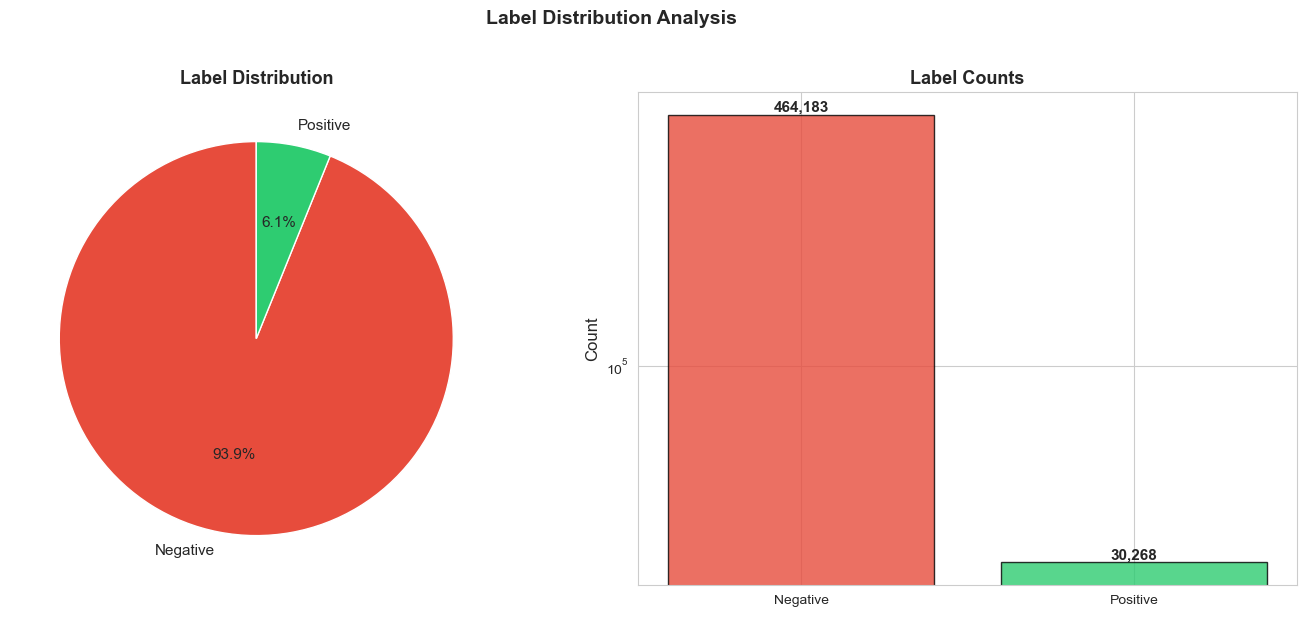

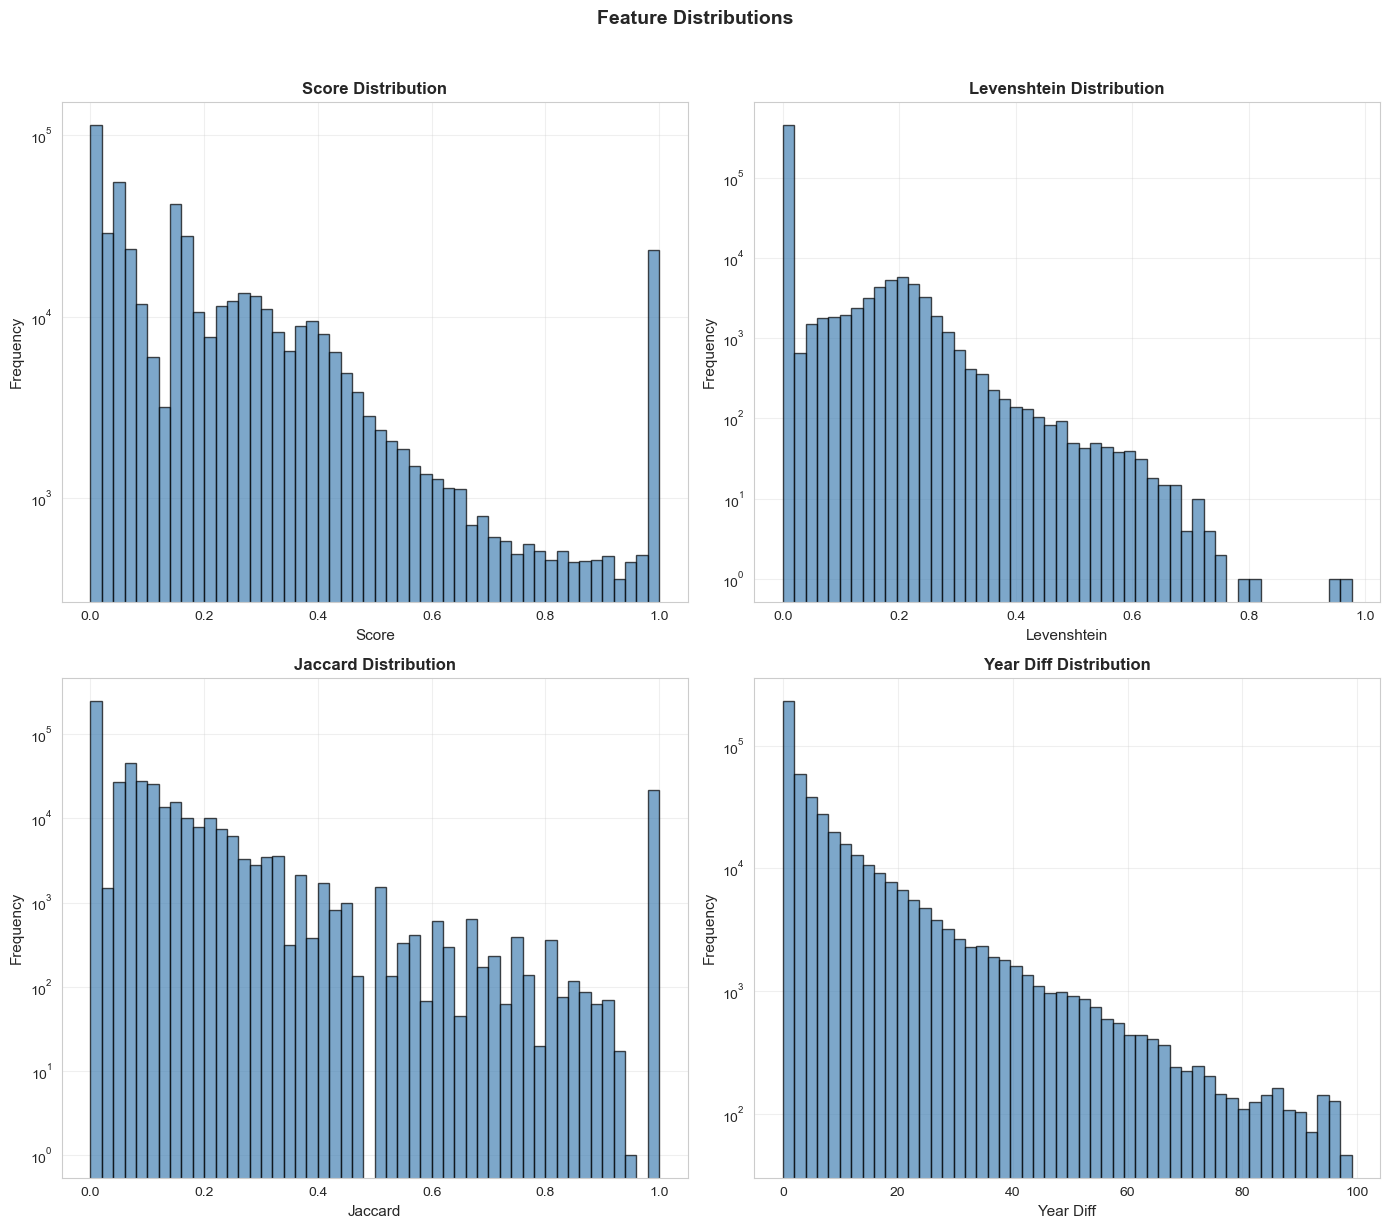

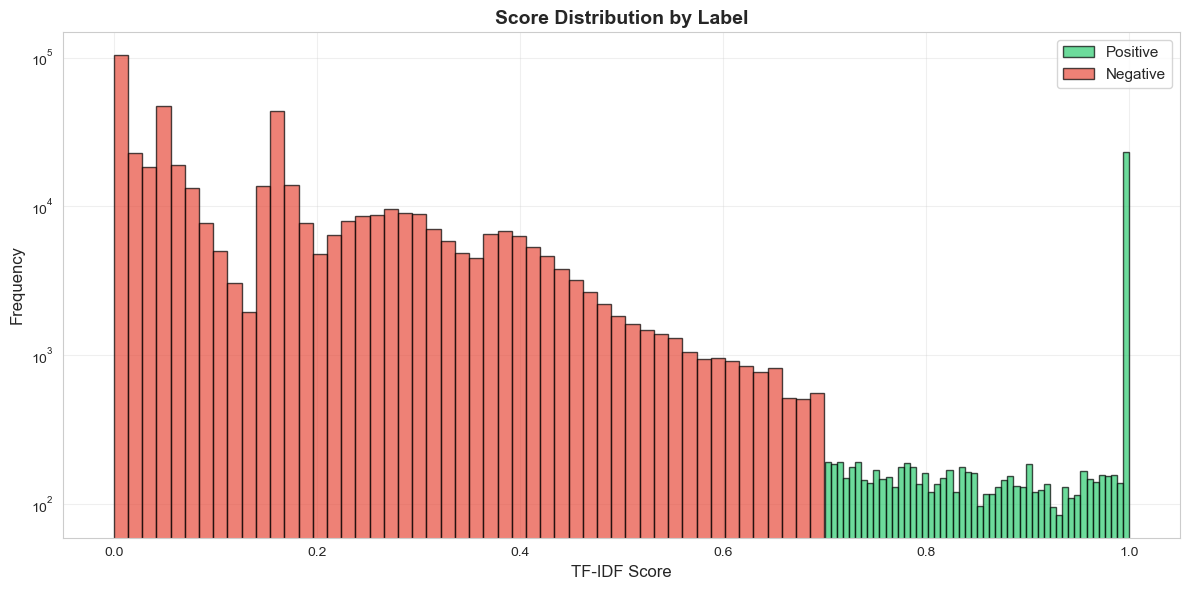

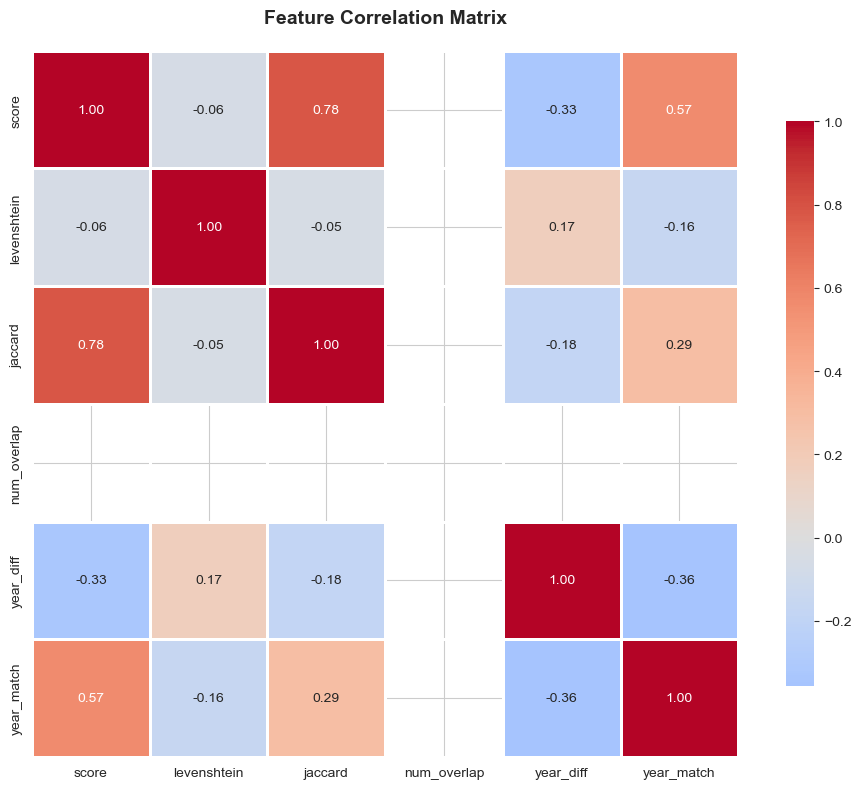

In [ ]:
# Import visualization functions
from visualization import visualize_matching_statistics

# Create comprehensive visualization dashboard
# Note: Run matching and splitting cells first to get complete statistics
if OUT_PATH.exists():
    # Get split_counts if available from split cell
    split_counts_local = None
    target_pct_local = None

    if 'split_counts' in globals():
        split_counts_local = split_counts
        target_pct_local = {'test': TARGET_TEST_PCT, 'val': TARGET_VAL_PCT}

    visualize_matching_statistics(
        matches_path=OUT_PATH,
        split_counts=split_counts_local,
        target_pct=target_pct_local
    )
else:
    print("Warning: matches_fe.jsonl not found. Please run matching cell first.")


## Data Splitting

Split the matched data into train/validation/test sets:
- Automatic selection based on row counts to achieve target percentages
- Manual papers are prioritized for test/val sets
- Generate split JSONL files and pred.json files for each paper

In [ ]:
# Split data and generate pred.json files
if not OUT_PATH.exists():
    print("Error: matches_fe.jsonl not found. Please run matching cell first.")
else:
    split_map, split_counts = split_data(
        matches_path=OUT_PATH,
        manual_map=MANUAL_MAP,
        bib_by_pid=bib_by_pid,
        ref_by_pid=ref_by_pid,
        test_ids=TEST_IDS if TEST_IDS else None,
        val_ids=VAL_IDS if VAL_IDS else None,
        split_dir=SPLIT_DIR,
        pred_dir=PRED_DIR,
        target_test_pct=TARGET_TEST_PCT,
        target_val_pct=TARGET_VAL_PCT
    )

    print(f"\nSplit complete:")
    print(f"  Test papers: {len([p for p, s in split_map.items() if s == 'test'])}")
    print(f"  Val papers: {len([p for p, s in split_map.items() if s == 'val'])}")
    print(f"  Train papers: {len([p for p, s in split_map.items() if s == 'train'])}")




Split rows target: Test=61,806 (12.5%), Val=61,806 (12.5%)
Split rows actual: Test=2,569 (0.5%), Val=2,547 (0.5%), Train=489,335 (99.0%)
Test papers: ['2408-02503', '2408-03239'], Val papers: ['2408-02505', '2408-02602']
Split jsonl counts: {'train': 489406, 'test': 2597, 'val': 2574}
pred.json written: 532 files under 23120334\23120334

Split complete:
  Test papers: 2
  Val papers: 2
  Train papers: 528
